In [3]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

# Implementing the Perceptron Algorithm

## Part A: Implement Perceptron

First, get data from warmup.

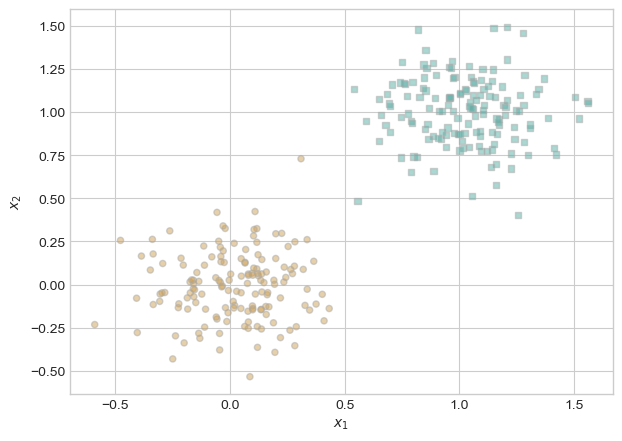

In [42]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

See if perceptron.py code is function by run the “minimal training loop” code from this section of the notes and eventually achieve loss = 0 on linearly separable data.

In [5]:
from perceptron import Perceptron, PerceptronOptimizer

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # print(f"{loss=}")

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

Show visualizations of the data, the separating line, and the evolution of the loss function during training.

I copied the graph from notes in class.

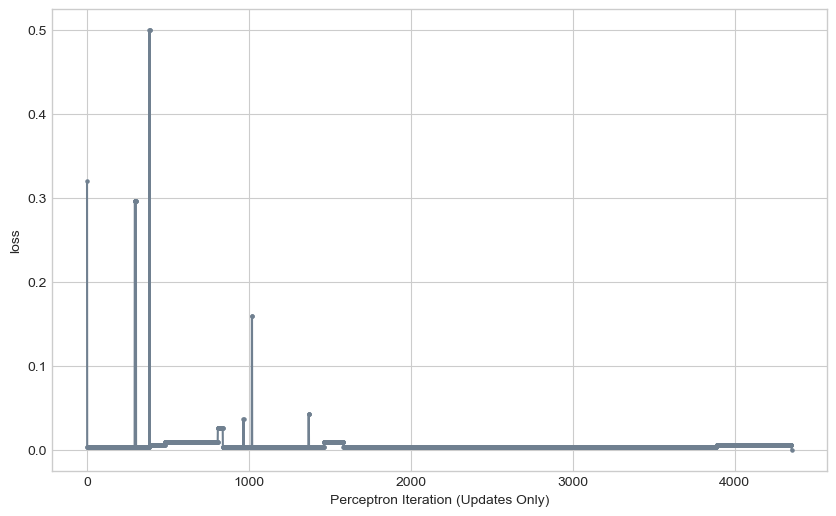

In [28]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s=5)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Used some of the code from the class lecture to visualize  

In [30]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

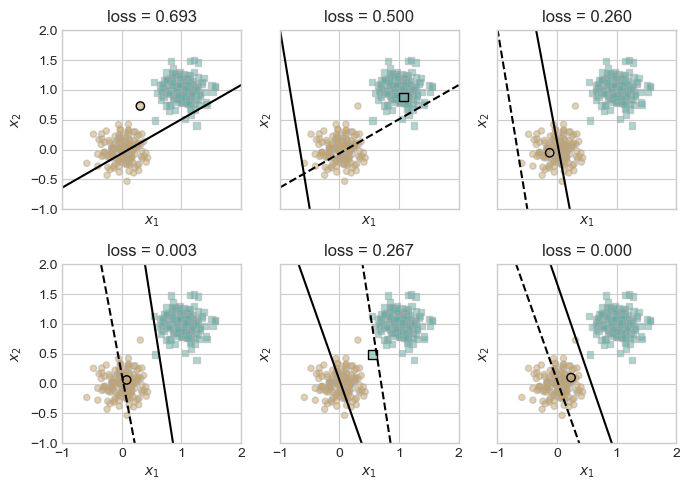

In [34]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(x_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

## data is not linearly separable

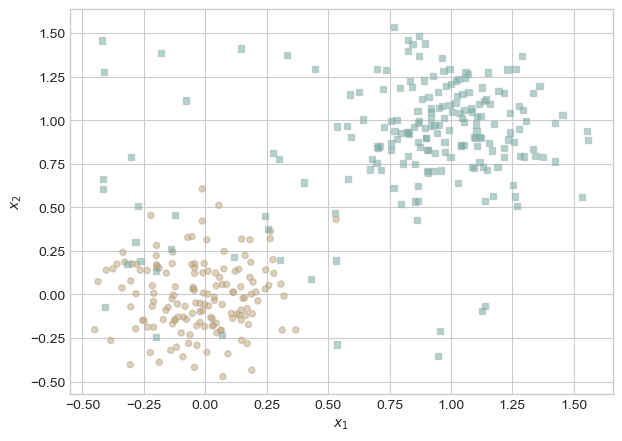

In [57]:
import torch
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(1234)

def perceptron_data_overlap(n_points=300, noise=0.2, p_dims=2, overlap_points=50):
   
    y = torch.arange(n_points) >= int(n_points / 2)
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # Add overlapping points within the range of existing points
    overlap_X = torch.rand(overlap_points, p_dims) * (X.max() - X.min()) + X.min()
    overlap_X = torch.cat((overlap_X, torch.ones((overlap_X.shape[0], 1))), 1)  # Add bias term
    X = torch.cat((X, overlap_X), dim=0)

    # Convert y from {0, 1} to {-1, 1}
    y = torch.cat((2 * y - 1, torch.ones(overlap_points, dtype=torch.long)))  # Label the overlapping points as class 1

    return X, y

def plot_perceptron_data_overlap(X, y, ax):
    targets = [-1, 1]
    markers = ["o", ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix, 0], X[ix, 1], s=20, c=y[ix], facecolors="none", edgecolors="darkgrey", cmap="BrBG", vmin=-2, vmax=2, alpha=0.5, marker=markers[i])
    ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data_overlap()
plot_perceptron_data_overlap(X, y, ax)
plt.show()

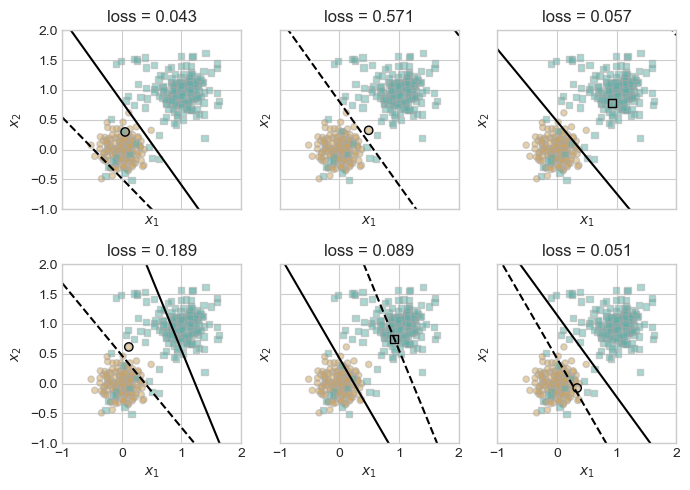

In [67]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
X, y = perceptron_data_overlap()
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

for index in range(0, 1000):
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(x_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if (local_loss > 0 and current_ax<6):
        plot_perceptron_data_overlap(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        
        if (current_ax < 5):
            current_ax += 1
plt.tight_layout()

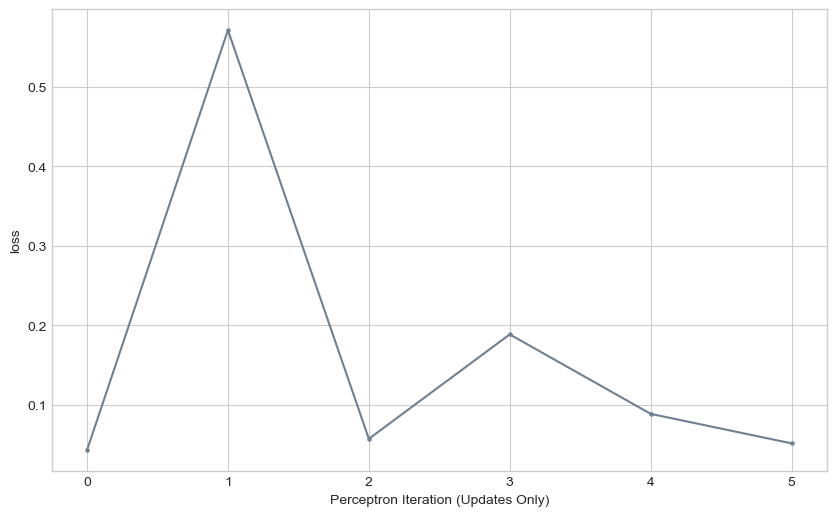

In [68]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s=5)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

## Data with more than 2 dimensions

In [69]:
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims = 5)

FIX BELOW

In [ ]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

for index in range(0, 1000):
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    z_i = z[i]

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(x_i, y_i)

        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()